# 👋 About Me

Hi, I'm Daniil Litvinenko, currently an upcoming TIP intern at Capital One. I’m deeply interested in machine learning and am working to transition into a more ML-focused role within the company.

This notebook is a self-contained project I completed to demonstrate:
- My comfort with core ML workflows (data preprocessing, model selection, evaluation)
- My ability to explain concepts clearly through code and visualizations
- My enthusiasm for ML and continuous learning

I hope this example gives a good sense of my capabilities and how I’d contribute to the ML team.

_Thanks for taking the time to review!_


# 🧠 Objective

In this project, I train a polynomial regression model to recover a sinusoidal function from noisy data. The key goals are:

- To evaluate the effect of regularization using Ridge regression  
- To use cross-validation for model selection  
- To compare performance between small and larger training sets  
- To visualize model predictions and evaluate generalization with test MSE


# 📊 Step 1: Train on a Small Dataset (25 points) Using Ridge Regularization

We begin by generating 10th-degree polynomial features from 25 training samples and training six models with varying regularization parameters (λ).  

We apply **5-fold cross-validation** to estimate generalization performance and select the best model based on average validation MSE.


In [ ]:
import numpy as np
import pandas as pd

global_train_x=np.load("train.npz")["x"]# 25 data points
global_train_y=np.load("train.npz")["y"]

feature_matrix = np.column_stack([global_train_x**i for i in range(10)])

ridge_params = [0, 1e-8, 1e-5, 1e-2, 0.5, 1]
res = []
for lmbda in ridge_params: # all models, 5 folds per model
  MSE_sum = 0

  folds_count = 5
  N = feature_matrix.shape[0] // folds_count

  w_vectors = []
  for i in range(folds_count): # each fold per some single model
    cut_start = i * N
    cut_end = (i + 1) * N

    validation = feature_matrix[cut_start:cut_end]
    train = np.concatenate([feature_matrix[:cut_start], feature_matrix[cut_end:]], axis=0)

    y_val = global_train_y[cut_start:cut_end]
    y_train = np.concatenate([global_train_y[:cut_start], global_train_y[cut_end:]], axis=0)
    

    w = np.linalg.pinv(train.T@train + lmbda * np.identity(train.shape[1])) @ train.T @ y_train
    w_vectors.append(w)

    # MSE
    MSE_sum += np.mean((validation @ w - y_val) ** 2)
  

  MSE_sum /= folds_count
  res.append({'w vectors': w_vectors, 'mse': MSE_sum, 'lambda value': lmbda})

# ✅ Step 2: Select the Best and Worst Models (Based on Validation MSE)

After training, we sort the models by validation error and extract both:

- The best model (`λ = λ*`) from cross-validation  
- The unregularized model (`λ = 0`), representing ordinary least squares (OLS)


In [40]:
res = pd.DataFrame(res)
res = res.sort_values(by='mse', ascending=True)

# keep the best model, and the worst model (it's always lambda = 0)
res = res.iloc[[0, -1]]

# Store the avg weights vectors that we got from cross validation per model as 'avg_w'
res['avg_w'] = res['w vectors'].apply(lambda w_list: np.mean(np.array(w_list), axis=0))
res.reset_index(drop=True, inplace=True)

# 📈 Step 3: Plot the Best and Worst Models

We plot both the OLS and the regularized model predictions on the 25-point training data.  

This visual comparison highlights how regularization reduces overfitting and improves generalization.


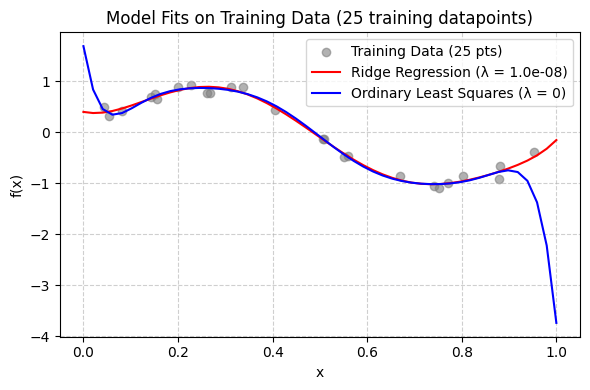

In [ ]:
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 50)
y_ridge = []
y_OLS = []
w_ridge = res.loc[0, 'avg_w']
w_OLS = res.loc[1, 'avg_w']
for x_coord in x:
  y_coord_ridge = 0
  y_coord_OLS = 0
  for i in range(10):
    y_coord_ridge += w_ridge[i] * (x_coord ** i)
    y_coord_OLS += w_OLS[i] * (x_coord ** i)

  y_ridge.append(y_coord_ridge)
  y_OLS.append(y_coord_OLS)
  


plt.figure(figsize=(6, 4))
plt.scatter(global_train_x, global_train_y, color='grey', alpha=0.6, label='Training Data (25 pts)')
plt.plot(x, y_ridge, color='red', label=f'Ridge Regression (λ = {res.loc[0, "lambda value"]:.1e})')
plt.plot(x, y_OLS, color='blue', label='Ordinary Least Squares (λ = 0)')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Model Fits on Training Data (25 training datapoints)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# 🧪 Step 4: Evaluate Both Models on Test Data

We apply the best model (`λ*`) and the OLS model to a separate 100-point test set and report the resulting test MSEs.  

This allows us to quantitatively compare their generalization performance.


In [43]:
test_x=np.load("test.npz")["x"] # 100 data points
test_y=np.load("test.npz")["y"]

feature_matrix = np.column_stack([test_x**i for i in range(10)])

y_predict_ridge = feature_matrix @ w_ridge
y_predict_OLS = feature_matrix @ w_OLS

MSE_ridge = np.mean((test_y - y_predict_ridge) ** 2)
MSE_OLS = np.mean((test_y - y_predict_OLS) ** 2)
print(f"Ridge MSE result: {MSE_ridge:.2f}")
print(f"Unregularized MSE result: {MSE_OLS:.2f}")

Ridge MSE result: 0.04
Unregularized MSE result: 0.44


# 🚀 Step 5: Retrain the Best Model on a Larger Dataset (100 Points)

To further investigate the role of data size, we retrain the best model (with the same `λ*` from cross-validation) using a larger training set of 100 points.  

We plot its predictions and evaluate test performance again.


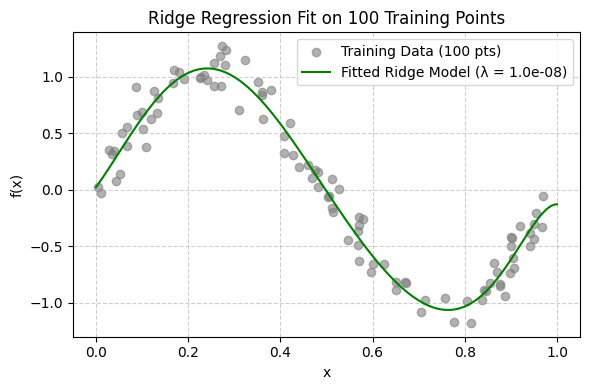

In [44]:
train_x_100=np.load("train_100.npz")["x"] # 100 data points
train_y_100=np.load("train_100.npz")["y"]

feature_matrix = np.column_stack([train_x_100**i for i in range(10)])

best_lambda = res['lambda value'][0]
w = np.linalg.pinv(feature_matrix.T@feature_matrix + best_lambda * np.identity(feature_matrix.shape[1])) @ feature_matrix.T @ train_y_100


x = np.linspace(0, 1, 500)
y = []
for x_coord in x:
  y_coord= 0
  for i in range(10):
    y_coord += w[i] * (x_coord ** i)

  y.append(y_coord)




plt.figure(figsize=(6, 4))
plt.scatter(train_x_100, train_y_100, color='grey', alpha=0.6, label='Training Data (100 pts)')
plt.plot(x, y, color='green', label=f'Fitted Ridge Model (λ = {best_lambda:.1e})')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Ridge Regression Fit on 100 Training Points')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


# test against the testing dataset
test_x=np.load("test.npz")["x"] # 100 data points
test_y=np.load("test.npz")["y"]

feature_matrix = np.column_stack([test_x**i for i in range(10)])

y_predicted = feature_matrix @ w
MSE_train_100 = np.mean((test_y - y_predicted) ** 2)

# 📊 Step 6: Compare All Three Models Using Test MSE

We compare test performance of the following models using a bar chart:

- Ridge Regression (trained on 25 points with cross-validated λ*)  
- Ordinary Least Squares (trained on 25 points, λ = 0)  
- Ridge Regression (trained on 100 points using λ*)  

This comparison shows how both **regularization** and **increased data** help reduce generalization error.


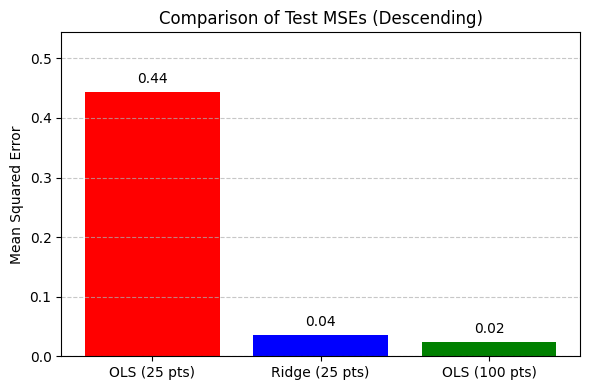

In [45]:
# combine and sort by value descending
data = list(zip(['Ridge (25 pts)', 'OLS (25 pts)', 'OLS (100 pts)'], [MSE_ridge, MSE_OLS, MSE_train_100]))
data_sorted = sorted(data, key=lambda x: x[1], reverse=True)

labels, values = zip(*data_sorted)
# plot
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values, color=['red', 'blue', 'green'])

# Annotate bars
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

plt.ylabel('Mean Squared Error')
plt.title('Comparison of Test MSEs (Descending)')
plt.ylim(0, max(values) + 0.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 💡 Key Takeaways

- Regularization (Ridge regression) significantly improves model generalization when training data is limited.  
- Cross-validation is effective for selecting the optimal regularization parameter.  
- Increasing training data reduces overfitting and lowers test error, even with simple models.  
- Model selection and effective regularization are key techniques in controlling complexity in machine learning.
